# Calibration results. Stock: TSLA

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import statsmodels.api as sm
import random
import seaborn as sns
import scipy.stats as stats
import sys
import warnings
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
plt.style.use('default')
warnings.simplefilter(action='ignore', category=FutureWarning)

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer
random.seed(120)

The calibration process has gone through 5 steps:
1. Calibration of model parameters based on **CALLS** option prices.
2. Calibration of model parameters based on **PUTS** option prices.
3. Calibration of model parameters based on **One-Touch-Knock-Out Daily Cliquets (OTKO)** option prices.
4. Calibration of model parameters based on a set of mixed options: **CALLS and OTKO** prices.
5. Calibration of model parameters based on a set of mixed options: **PUTS and OTKO** prices.

Now, we are ready to visualize and analyze the results of each process. in order to decide which set of parameters fits best our pricing model.

In [14]:
#STOCK SPLIT: 4:1 ON 31-08-2020 (FROM 2016 TO DATE)

# Retrieving all dataframes for tsla stock
data = pd.read_csv('../../data/TSLA/TSLA_data.csv')            # NB. dal 20-01-2016 al 19-01-2018
calls = pd.read_csv('../../data/TSLA/TSLA_calls.csv')
puts = pd.read_csv('../../data/TSLA/TSLA_puts.csv')
otko = pd.read_csv('../../data/TSLA/tsla_otko_1year.csv')

# STOCK SPLIT ADJUSTMENT
data[['Open', 'High', 'Low', 'Close']] = 4*data[['Open', 'High', 'Low', 'Close']]
print(data)

           Date       Open       High        Low      Close     Volume  \
0    2016-01-20  53.173332  53.674667  51.000000  52.986668   87579000   
1    2016-01-21  53.746670  54.194668  52.005333  53.325333   47493000   
2    2016-01-22  54.613331  54.799999  53.074669  54.013332   46861500   
3    2016-01-25  53.349331  54.285332  52.234669  52.368000   40480500   
4    2016-01-26  52.453331  52.751999  50.368000  51.616001   74463000   
..          ...        ...        ...        ...        ...        ...   
500  2018-01-12  90.301331  90.776001  88.978668  89.658669   72376500   
501  2018-01-16  90.010666  92.000000  89.279999  90.682671   97114500   
502  2018-01-17  90.792000  93.066666  90.599998  92.575996  106552500   
503  2018-01-18  92.178665  93.946671  91.664001  91.885330   85287000   
504  2018-01-19  92.000000  93.490669  91.360001  93.338669   73324500   

      Returns  Log Returns  Returns (%)  
0         NaN          NaN          NaN  
1    1.006392     0.006371 

In [15]:
# Define general parameters
T = 1
r = 0.03
q = 0
exercise = 'european'
S0 = calls.iloc[0]['UNDERLYING_LAST']
print(S0)

198.7


#### Retrieve parameters found by each calibration

In [16]:
%store -r calls_bs_params_tsla
%store -r calls_mert_params_tsla
%store -r calls_kou_params_tsla
%store -r calls_vg_params_tsla

In [17]:
%store -r puts_bs_params_tsla
%store -r puts_mert_params_tsla
%store -r puts_kou_params_tsla
%store -r puts_vg_params_tsla

In [18]:
%store -r otko_mert_params_tsla
%store -r otko_kou_params_tsla
%store -r otko_vg_params_tsla

In [19]:
%store -r calls_otko_mert_params_tsla
%store -r calls_otko_kou_params_tsla
%store -r calls_otko_vg_params_tsla

In [20]:
%store -r puts_otko_mert_params_tsla
%store -r puts_otko_kou_params_tsla
%store -r puts_otko_vg_params_tsla


In [21]:
BS_1 = BS_Pricer(S0, None, T, r, q, calls_bs_params_tsla, exercise)
BS_2 = BS_Pricer(S0, None, T, r, q, puts_bs_params_tsla, exercise)

## Results that show the goodness of our calibration process
### 1. Repricing all options using all the sets of calibrated parameters


In [22]:
# define simulation parameters
days = 252
paths = 10000

#####  Merton model

In [23]:
# SOLE CALLS
sigma, lambd, m, v = calls_mert_params_tsla
Mert1 = Merton_pricer(S0, None, T, r, q, sigma, lambd, m, v, exercise)
Smert1 = Mert1.MertonPath(days, paths)

# SOLE PUTS
sigma, lambd, m, v = puts_mert_params_tsla
Mert2 = Merton_pricer(S0, None, T, r, q, sigma, lambd, m, v, exercise)
Smert2 = Mert2.MertonPath(days, paths)

# OTKO
sigma, lambd, m, v = otko_mert_params_tsla
Mert3 = Merton_pricer(S0, None, T, r, q, sigma, lambd, m, v, exercise)
Smert3 = Mert3.MertonPath(days, paths)


# CALLS+OTKO
sigma, lambd, m, v = calls_otko_mert_params_tsla
Mert4 = Merton_pricer(S0, None, T, r, q, sigma, lambd, m, v, exercise)
Smert4 = Mert4.MertonPath(days, paths)

# PUTS + OTKO
sigma, lambd, m, v = puts_otko_mert_params_tsla
Mert5 = Merton_pricer(S0, None, T, r, q, sigma, lambd, m, v, exercise)
Smert5 = Mert5.MertonPath(days, paths)

#### 1.1. Reprice plain vanilla with the 3 set of parameters

In [24]:
call_prices = calls['C_Midpoint']
call_strikes = calls['STRIKE']

calls_mert_repriced_1 = np.zeros(len(call_prices))
calls_mert_repriced_3 = np.zeros(len(call_prices))
calls_mert_repriced_4 = np.zeros(len(call_prices))

for index in range(len(call_strikes)):
    calls_mert_repriced_1[index] = Mert1.closed_formula_call(call_strikes[index])  # SOLO CALLS PARAMETERS
    calls_mert_repriced_3[index] = Mert3.closed_formula_call(call_strikes[index])  # SOLO OTKO PARAMETERS
    calls_mert_repriced_4[index] = Mert4.closed_formula_call(call_strikes[index])  # MIXED CALLS+OTKO PARAMETERS

Repricing **CALLS**. The set of parameters used in our Merton Jump Diffusion will be:
1. Parameters calibrated on CALL options only
2. Parameters calibrated on OTKO options only
3. Parameters calibrated on MIXED calibration, with CALLS and OTKO

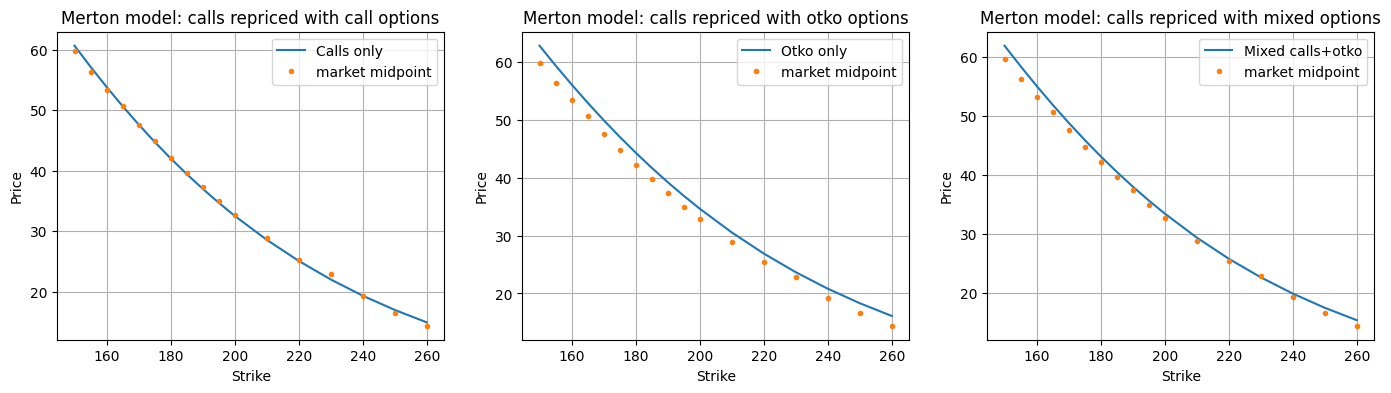

In [25]:
options = ['call', 'otko', 'mixed']
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, calls_mert_repriced_1, label="Calls only")
ax2.plot(call_strikes, calls_mert_repriced_3, label="Otko only")
ax3.plot(call_strikes, calls_mert_repriced_4, label="Mixed calls+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(call_strikes, call_prices, ".", label="market midpoint")
    ax.set_title(f"Merton model: calls repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

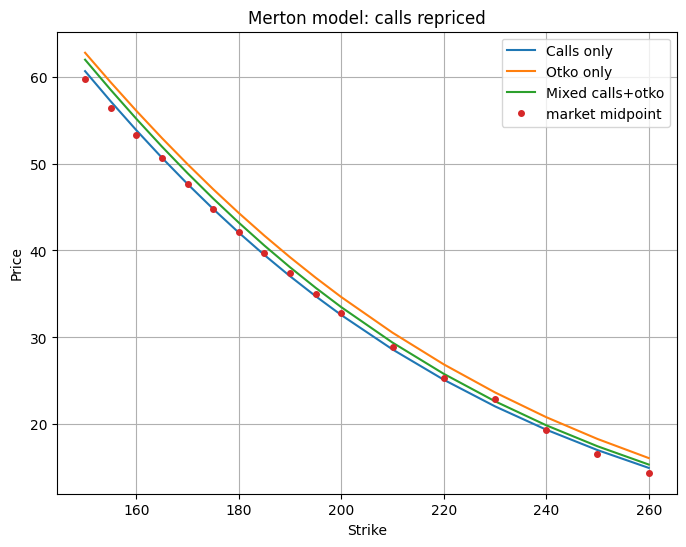

In [26]:
fig = plt.figure(figsize=(8, 6))
plt.plot(call_strikes, calls_mert_repriced_1, label="Calls only")
plt.plot(call_strikes, calls_mert_repriced_3, label="Otko only")
plt.plot(call_strikes, calls_mert_repriced_4, label="Mixed calls+otko")
plt.plot(call_strikes, call_prices, ".", label="market midpoint", markersize = 8)
plt.title("Merton model: calls repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [27]:
put_prices = puts['P_Midpoint']
put_strikes = puts['STRIKE']

puts_mert_repriced_2 = np.zeros(len(put_prices))
puts_mert_repriced_3 = np.zeros(len(put_prices))
puts_mert_repriced_5 = np.zeros(len(put_prices))

for index in range(len(put_strikes)):
    puts_mert_repriced_2[index] = Mert2.closed_formula_put(put_strikes[index])      # SOLO CALLS PARAMETERS
    puts_mert_repriced_3[index] = Mert3.closed_formula_put(put_strikes[index])      # SOLO OTKO PARAMETERS
    puts_mert_repriced_5[index] = Mert5.closed_formula_put(put_strikes[index])      # MIXED CALLS+OTKO PARAMETERS

Repricing **PUTS**. The set of parameters used in our Merton Jump Diffusion will be:
1. Parameters calibrated on **put** options only
2. Parameters calibrated on **otko** options only
3. Parameters calibrated on **mixed** calibration, with **put** and **otko**

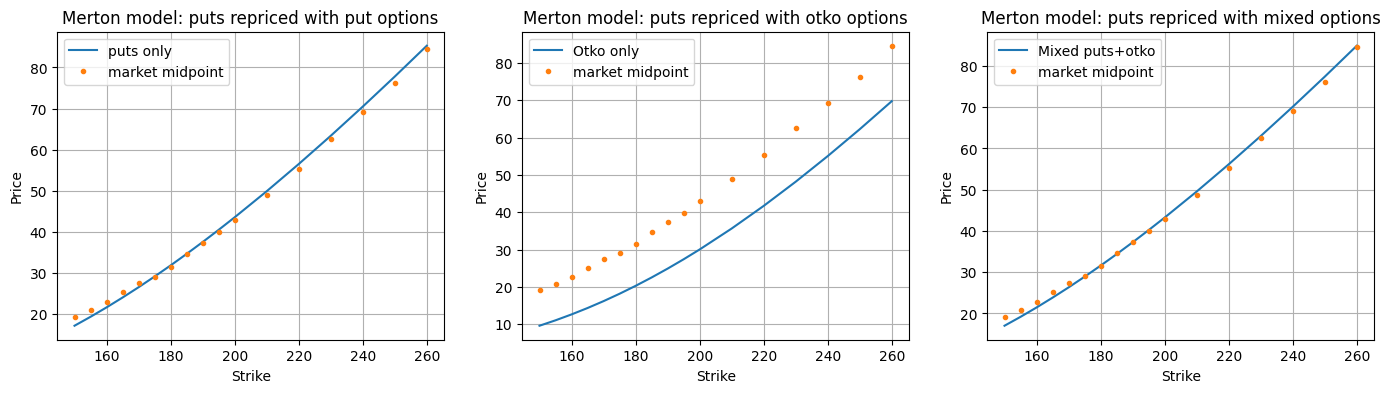

In [28]:
options = ['put', 'otko', 'mixed']
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, puts_mert_repriced_2, label="puts only")
ax2.plot(put_strikes, puts_mert_repriced_3, label="Otko only")
ax3.plot(put_strikes, puts_mert_repriced_5, label="Mixed puts+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(put_strikes, put_prices, ".", label="market midpoint")
    ax.set_title(f"Merton model: puts repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

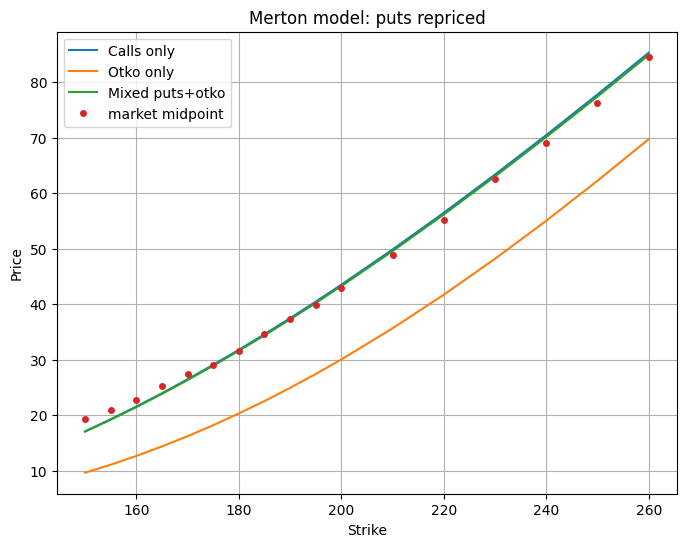

In [29]:
fig = plt.figure(figsize=(8, 6))
plt.plot(put_strikes, puts_mert_repriced_2, label="Calls only")
plt.plot(put_strikes, puts_mert_repriced_3, label="Otko only")
plt.plot(put_strikes, puts_mert_repriced_5, label="Mixed puts+otko")
plt.plot(put_strikes, put_prices, ".", label="market midpoint", markersize = 8)
plt.title("Merton model: puts repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### 1.2. Reprice OTKO options with all the set of parameters

In [30]:
otko_strikes = otko[['K1', 'K2']].values / 100
otko_prices = otko['Midpoint(%)']

otko_mert_repriced_1 = np.zeros(len(otko_prices))
otko_mert_repriced_2 = np.zeros(len(otko_prices))
otko_mert_repriced_3 = np.zeros(len(otko_prices))
otko_mert_repriced_4 = np.zeros(len(otko_prices))
otko_mert_repriced_5 = np.zeros(len(otko_prices))

for index in range(len(otko_strikes)):
    otko_mert_repriced_1[index] = Mert1.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO CALLS PARAMETERS
    otko_mert_repriced_2[index] = Mert2.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO PUTS PARAMETERS
    otko_mert_repriced_3[index] = Mert3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO OTKO PARAMETERS
    otko_mert_repriced_4[index] = Mert4.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # MIXED CALLS*OTKO PARAMETERS
    otko_mert_repriced_5[index] = Mert5.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # MIXED PUTS+OTKO PARAMETERS

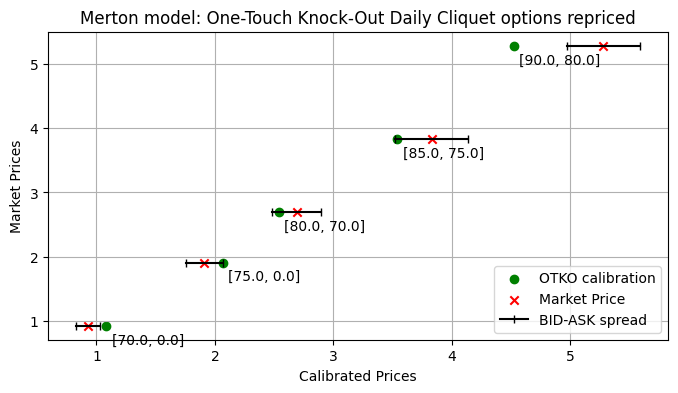

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(otko_mert_repriced_3, otko_prices, label='OTKO calibration', color='green', marker='o')

# Aggiunta di etichette per i punti
for i in range(len(otko_strikes)):
    offset_x = 4
    offset_y = -13
    plt.annotate(f"[{otko_strikes[i][0]*100}, {otko_strikes[i][1]*100}]", (otko_mert_repriced_3[i], otko_prices[i]),
                 textcoords="offset points",
                 xytext=(offset_x, offset_y))

# Aggiunta di una linea di riferimento
plt.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')
# Plot segments between bid, ask, and calibrated prices
for i in range(len(otko_strikes)):
    plt.plot([otko['BID(%)'][i], otko['ASK(%)'][i]], [otko_prices[i], otko_prices[i]], color='black', linestyle='-', marker='|')


# Aggiunta di etichette e titoli
plt.xlabel('Calibrated Prices')
plt.ylabel('Market Prices')
plt.title('Merton model: One-Touch Knock-Out Daily Cliquet options repriced')
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
handles.append(line) 
ax.legend(handles = handles, loc='lower right')
plt.grid()
# Mostra il grafico
plt.show()


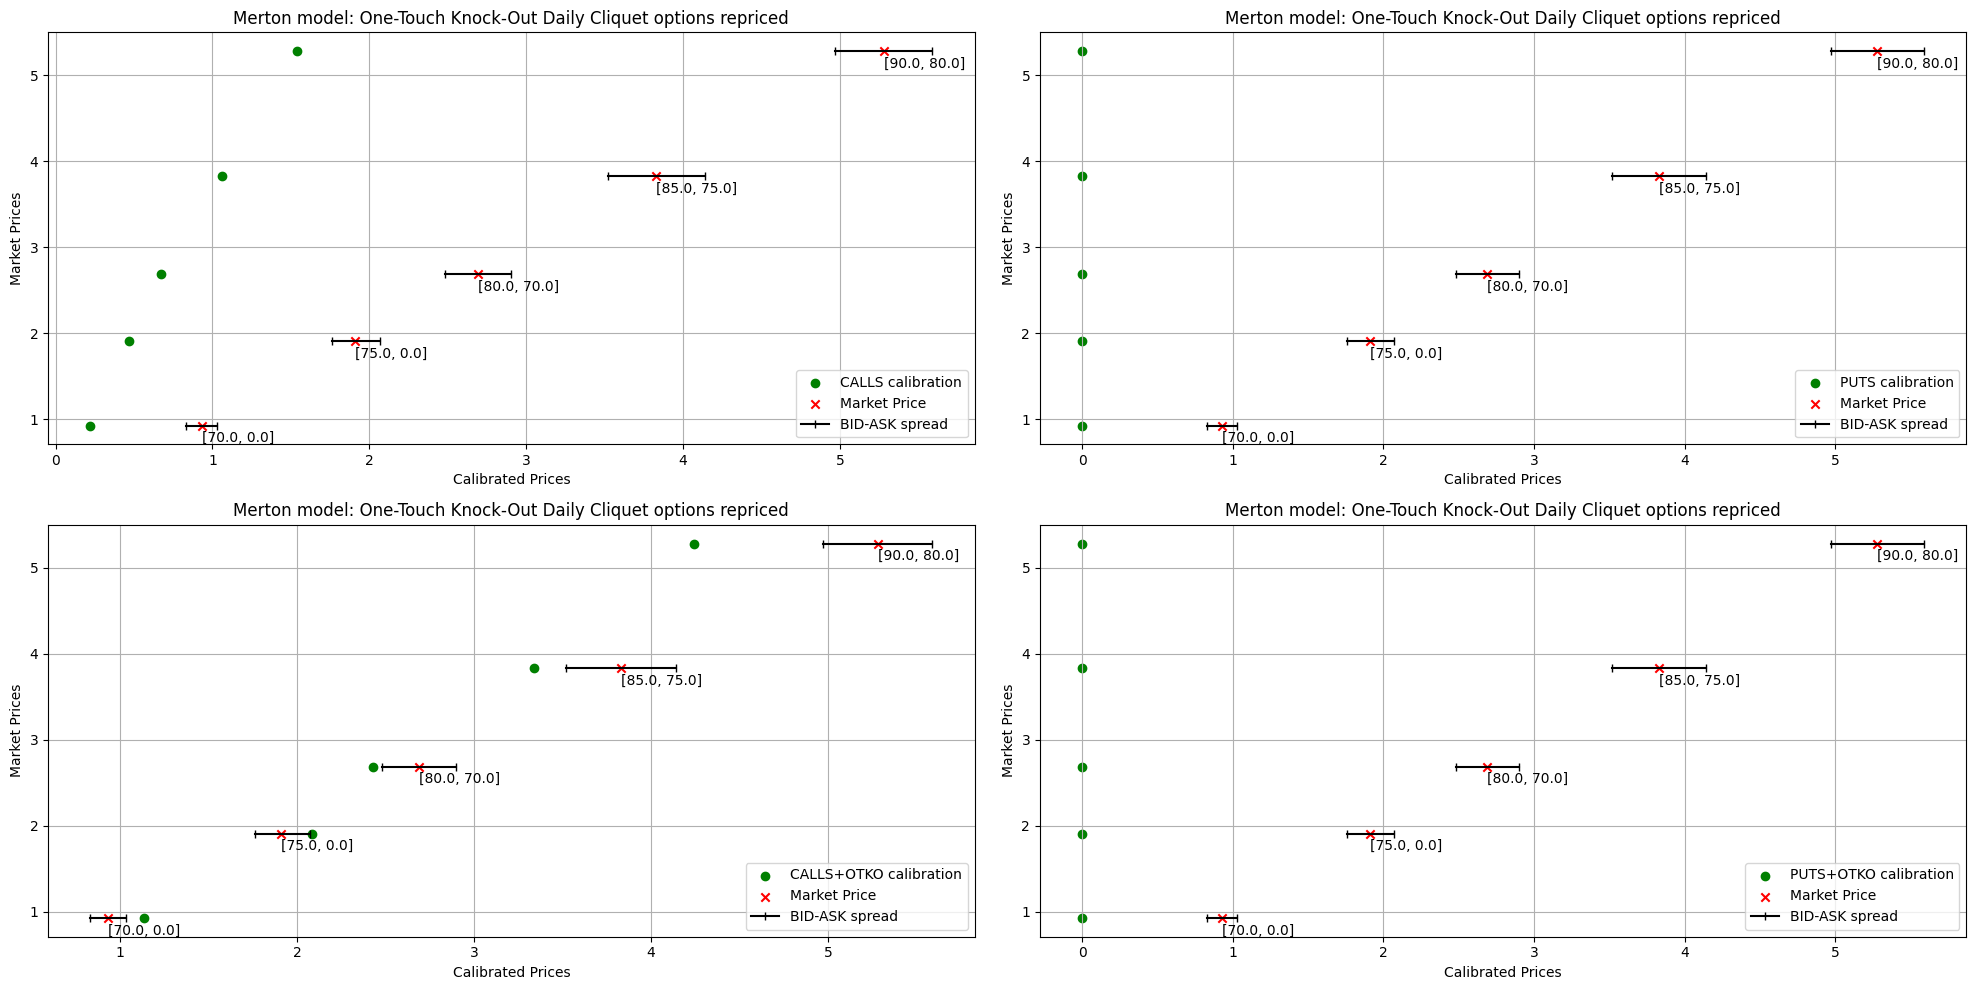

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes[0,0].scatter(otko_mert_repriced_1, otko_prices, label='CALLS calibration', color='green', marker='o')
axes[0,1].scatter(otko_mert_repriced_2, otko_prices, label='PUTS calibration', color='green', marker='o')
axes[1,0].scatter(otko_mert_repriced_4, otko_prices, label='CALLS+OTKO calibration', color='green', marker='o')
axes[1,1].scatter(otko_mert_repriced_5, otko_prices, label='PUTS+OTKO calibration', color='green', marker='o')


# Aggiunta di etichette per i punti
for i in range(2):
    for j in range(2):
        ax = axes[i, j]  # Get the current axis

        # Plot reference lines and segments between bid, ask, and calibrated prices
        ax.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')
        for k in range(len(otko_strikes)):
            ax.plot([otko['BID(%)'][k], otko['ASK(%)'][k]], [otko_prices[k], otko_prices[k]], color='black', linestyle='-', marker='|')

        for k in range(len(otko_strikes)):
            offset_x = 0
            offset_y = -12
            ax.annotate(f"[{otko_strikes[k][0]*100}, {otko_strikes[k][1]*100}]", (otko_prices[k], otko_prices[k]),
                        textcoords="offset points",
                        xytext=(offset_x, offset_y))

        # Aggiunta di etichette e titoli per ogni subplot
        ax.set_xlabel('Calibrated Prices')
        ax.set_ylabel('Market Prices')
        ax.set_title('Merton model: One-Touch Knock-Out Daily Cliquet options repriced')
        handles, labels = ax.get_legend_handles_labels()
        patch = mpatches.Patch(color = 'black', linestyle='-', label= 'BID-ASK spread')
        line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
        handles.append(line) 
        ax.legend(handles = handles, loc='lower right')
        ax.grid()

# Adjust layout
plt.tight_layout()

# Mostra il grafico
plt.show()

##### Kou Jump Diffusion


In [33]:
# SOLE CALLS
sigma, lambd, p, eta1, eta2 = calls_kou_params_tsla
Kou1 = Kou_pricer(S0, None, T, r, sigma, lambd,p, eta1, eta2, exercise)
Skou1 = Kou1.KouPath(days, paths)

# SOLE PUT
sigma, lambd, p, eta1, eta2 = puts_kou_params_tsla
Kou2 = Kou_pricer(S0, None, T, r, sigma, lambd,p, eta1, eta2, exercise)
Skou2 = Kou2.KouPath(days, paths)

# SOLE OTKO
sigma, lambd, p, eta1, eta2 = otko_kou_params_tsla
Kou3 = Kou_pricer(S0, None, T, r, sigma, lambd,p, eta1, eta2, exercise)
Skou3 = Kou3.KouPath(days, paths)

# MIXED CALLS+OTKO
sigma, lambd, p, eta1, eta2 = calls_otko_kou_params_tsla
Kou4 = Kou_pricer(S0, None, T, r, sigma, lambd,p, eta1, eta2, exercise)
Skou4 = Kou4.KouPath(days, paths)

# MIXED CALLS+OTKO
sigma, lambd, p, eta1, eta2 = puts_otko_kou_params_tsla
Kou5 = Kou_pricer(S0, None, T, r, sigma, lambd,p, eta1, eta2, exercise)
Skou5 = Kou5.KouPath(days, paths)

#### 1.1. Reprice plain vanilla with the 3 set of parameters

In [34]:
call_prices = calls['C_Midpoint']
call_strikes = calls['STRIKE']

calls_kou_repriced_1 = np.zeros(len(call_prices))
calls_kou_repriced_3 = np.zeros(len(call_prices))
calls_kou_repriced_4 = np.zeros(len(call_prices))

for index in range(len(call_strikes)):
    calls_kou_repriced_1[index] = Kou1.closed_formula_call(call_strikes[index])  # SOLO CALLS PARAMETERS
    calls_kou_repriced_3[index] = Kou3.closed_formula_call(call_strikes[index])  # SOLO OTKO PARAMETERS
    calls_kou_repriced_4[index] = Kou4.closed_formula_call(call_strikes[index])  # MIXED CALLS+OTKO PARAMETERS

Repricing **CALLS**. The set of parameters used in our Kou Jump Diffusion will be:
1. Parameters calibrated on CALL options only
2. Parameters calibrated on OTKO options only
3. Parameters calibrated on MIXED calibration, with CALLS and OTKO

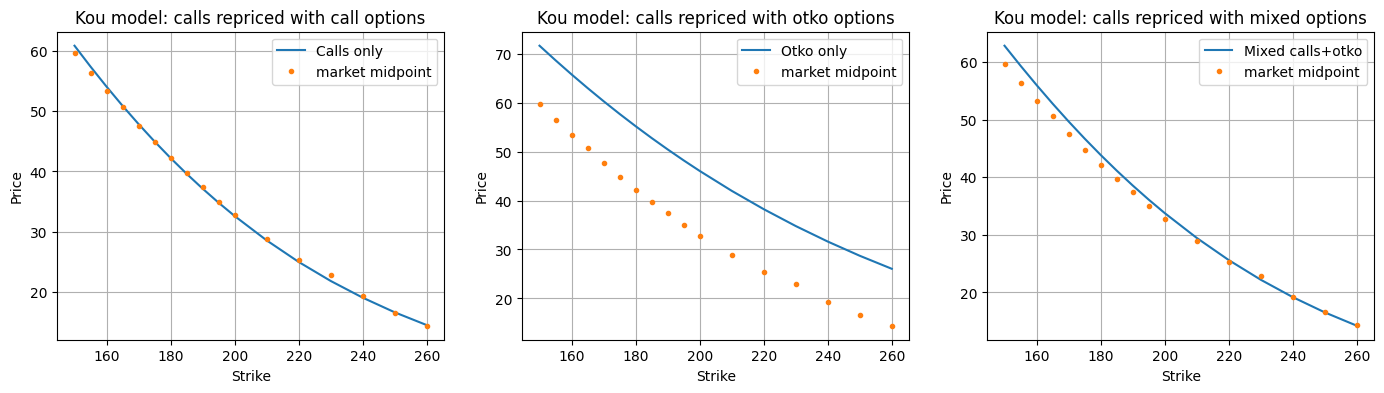

In [35]:
options = ['call', 'otko', 'mixed']

fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, calls_kou_repriced_1, label="Calls only")
ax2.plot(call_strikes, calls_kou_repriced_3, label="Otko only")
ax3.plot(call_strikes, calls_kou_repriced_4, label="Mixed calls+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(call_strikes, call_prices, ".", label="market midpoint")
    ax.set_title(f"Kou model: calls repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

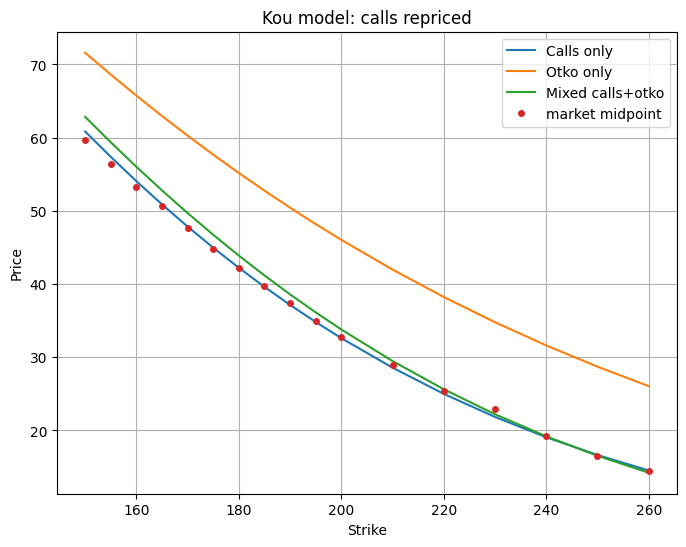

In [36]:
fig = plt.figure(figsize=(8, 6))

plt.plot(call_strikes, calls_kou_repriced_1, label="Calls only")
plt.plot(call_strikes, calls_kou_repriced_3, label="Otko only")
plt.plot(call_strikes, calls_kou_repriced_4, label="Mixed calls+otko")
plt.plot(call_strikes, call_prices, ".", label="market midpoint", markersize = 8)
plt.title("Kou model: calls repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [37]:
put_prices = puts['P_Midpoint']
put_strikes = puts['STRIKE']

puts_kou_repriced_2 = np.zeros(len(put_prices))
puts_kou_repriced_3 = np.zeros(len(put_prices))
puts_kou_repriced_5 = np.zeros(len(put_prices))

for index in range(len(put_strikes)):
    puts_kou_repriced_2[index] = Kou2.closed_formula_put(put_strikes[index])      # SOLO CALLS PARAMETERS
    puts_kou_repriced_3[index] = Kou3.closed_formula_put(put_strikes[index])      # SOLO OTKO PARAMETERS
    puts_kou_repriced_5[index] = Kou5.closed_formula_put(put_strikes[index])      # MIXED CALLS+OTKO PARAMETERS

Repricing **PUTS**. The set of parameters used in our Merton Jump Diffusion will be:
1. Parameters calibrated on **put** options only
2. Parameters calibrated on **otko** options only
3. Parameters calibrated on **mixed** calibration, with **put** and **otko**

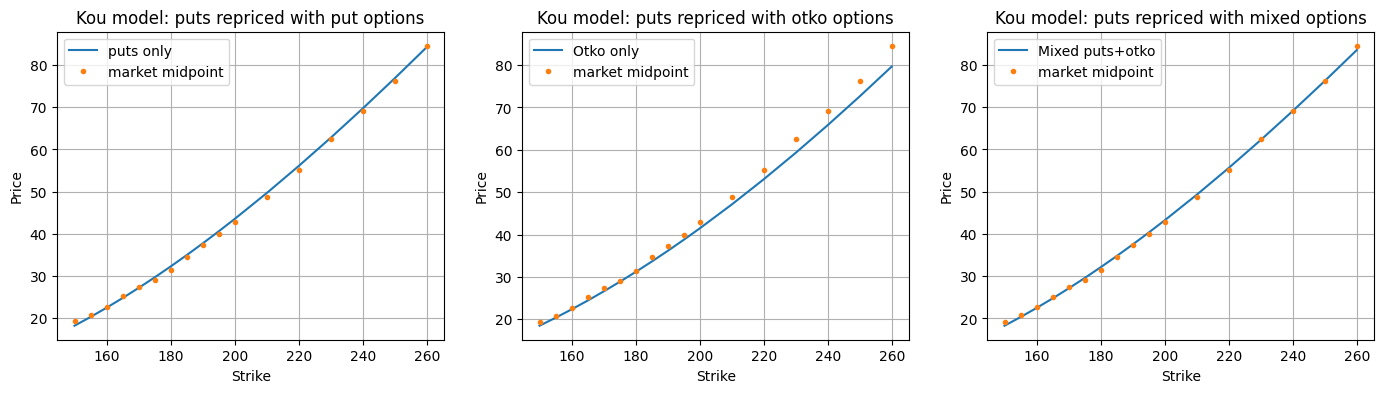

In [38]:
options = ['put', 'otko', 'mixed']

fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, puts_kou_repriced_2, label="puts only")
ax2.plot(put_strikes, puts_kou_repriced_3, label="Otko only")
ax3.plot(put_strikes, puts_kou_repriced_5, label="Mixed puts+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(put_strikes, put_prices, ".", label="market midpoint")
    ax.set_title(f"Kou model: puts repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

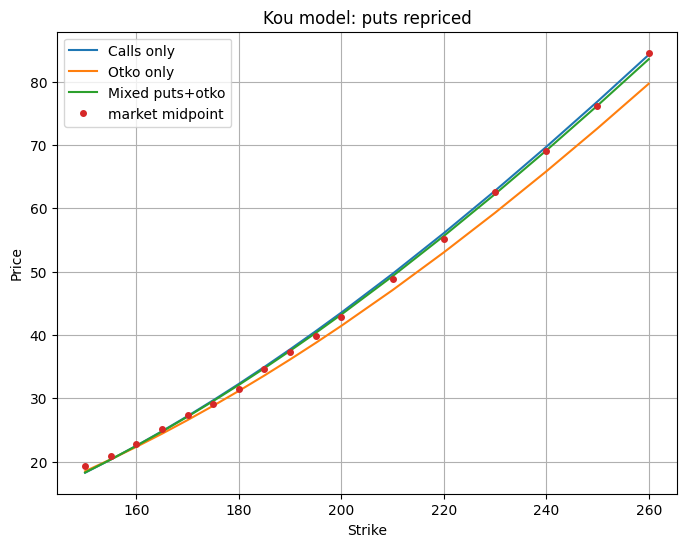

In [39]:
fig = plt.figure(figsize=(8, 6))

plt.plot(put_strikes, puts_kou_repriced_2, label="Calls only")
plt.plot(put_strikes, puts_kou_repriced_3, label="Otko only")
plt.plot(put_strikes, puts_kou_repriced_5, label="Mixed puts+otko")
plt.plot(put_strikes, put_prices, ".", label="market midpoint", markersize = 8)
plt.title("Kou model: puts repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### 1.2. Reprice OTKO options with all the set of parameters


In [40]:
otko_strikes = otko[['K1', 'K2']].values / 100
otko_prices = otko['Midpoint(%)']

otko_kou_repriced_1 = np.zeros(len(otko_prices))
otko_kou_repriced_2 = np.zeros(len(otko_prices))
otko_kou_repriced_3 = np.zeros(len(otko_prices))
otko_kou_repriced_4 = np.zeros(len(otko_prices))
otko_kou_repriced_5 = np.zeros(len(otko_prices))

for index in range(len(otko_strikes)):
    otko_kou_repriced_1[index] = Kou1.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO CALLS PARAMETERS
    otko_kou_repriced_2[index] = Kou2.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO PUTS PARAMETERS
    otko_kou_repriced_3[index] = Kou3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # SOLO OTKO PARAMETERS
    otko_kou_repriced_4[index] = Kou4.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # MIXED CALLS*OTKO PARAMETERS
    otko_kou_repriced_5[index] = Kou5.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])      # MIXED PUTS+OTKO PARAMETERS

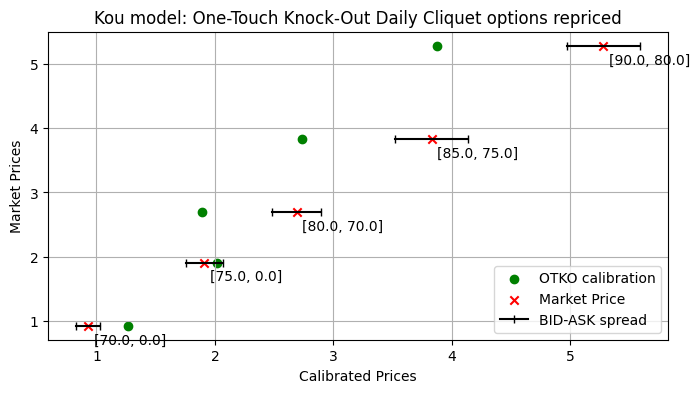

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(otko_kou_repriced_3, otko_prices, label='OTKO calibration', color='green', marker='o')

# Aggiunta di una linea di riferimento
plt.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')

# Aggiunta di etichette per i punti
for i in range(len(otko_strikes)):
    offset_x = 4
    offset_y = -13
    plt.annotate(f"[{otko_strikes[i][0]*100}, {otko_strikes[i][1]*100}]", (otko_prices[i], otko_prices[i]),
                 textcoords="offset points",
                 xytext=(offset_x, offset_y))

# Plot segments between bid, ask, and calibrated prices
for i in range(len(otko_strikes)):
    plt.plot([otko['BID(%)'][i], otko['ASK(%)'][i]], [otko_prices[i], otko_prices[i]], color='black', linestyle='-', marker='|')


# Aggiunta di etichette e titoli
plt.xlabel('Calibrated Prices')
plt.ylabel('Market Prices')
plt.title('Kou model: One-Touch Knock-Out Daily Cliquet options repriced')
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
handles.append(line) 
ax.legend(handles = handles, loc='lower right')
plt.grid()

# Mostra il grafico
plt.show()

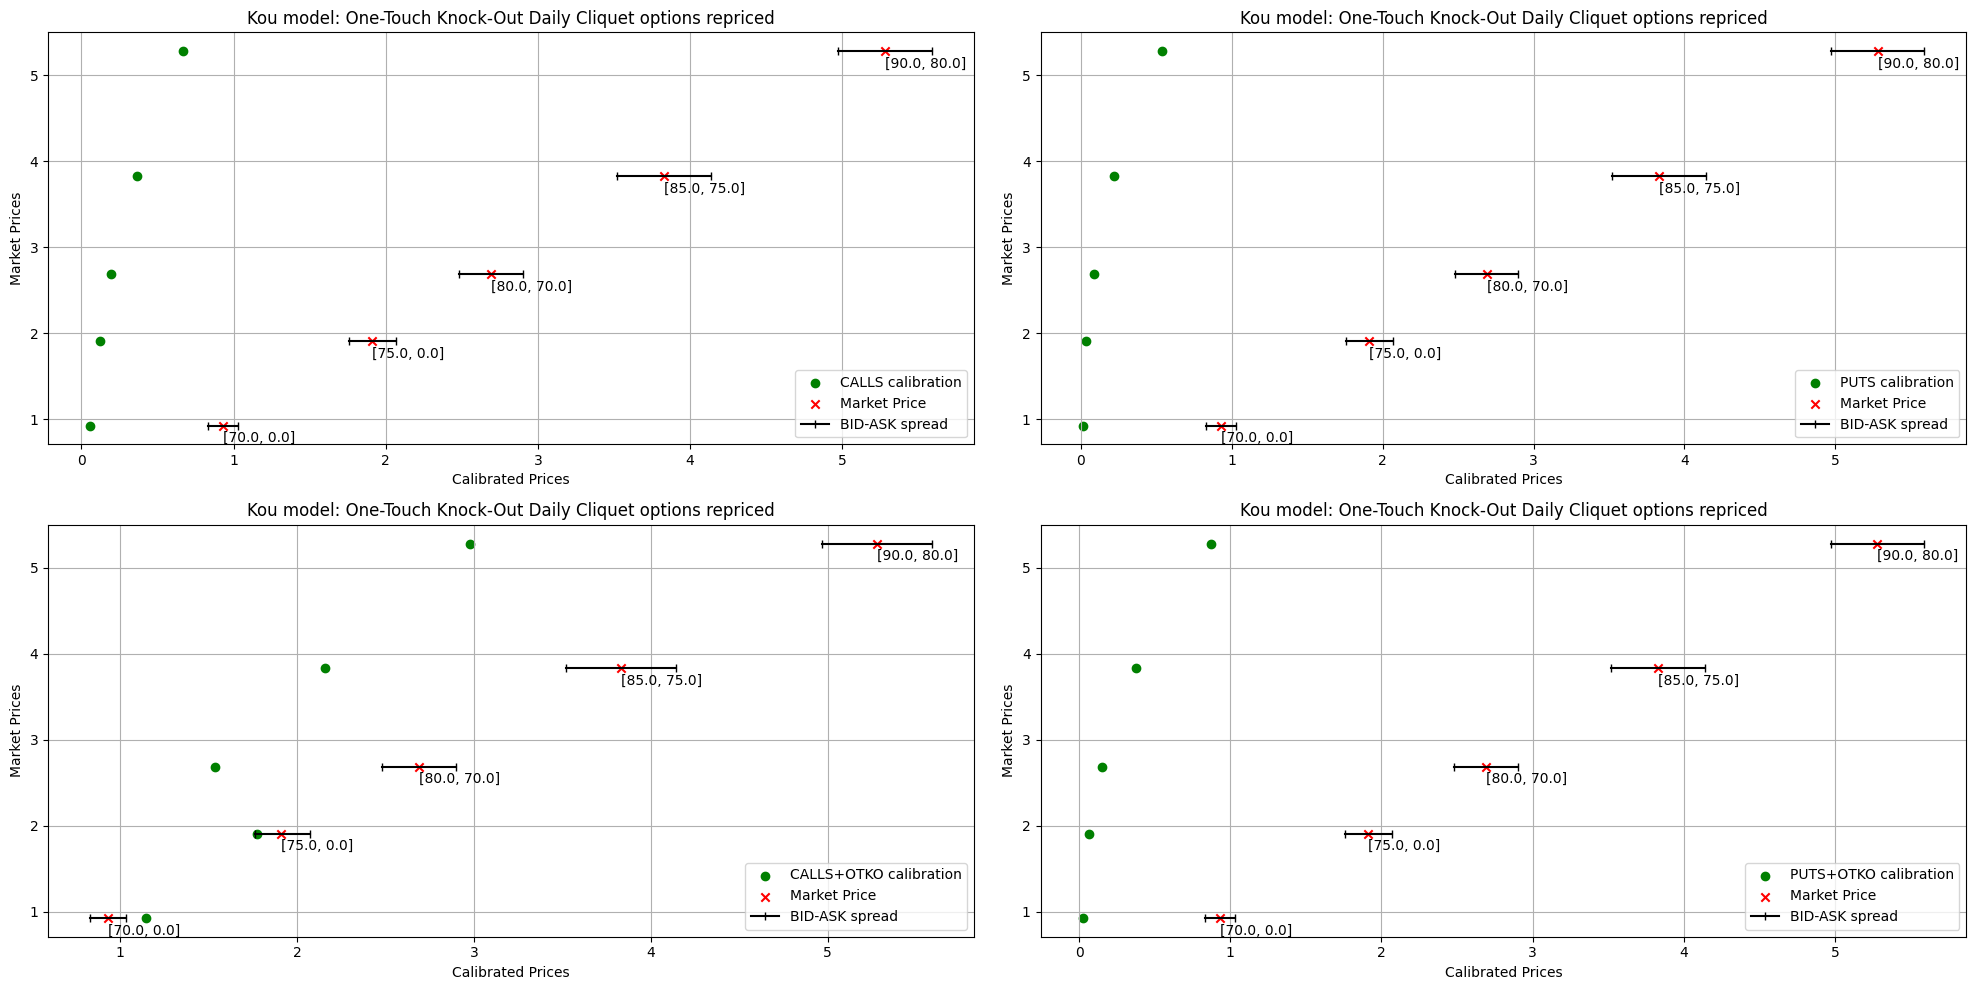

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes[0,0].scatter(otko_kou_repriced_1, otko_prices, label='CALLS calibration', color='green', marker='o')
axes[0,1].scatter(otko_kou_repriced_2, otko_prices, label='PUTS calibration', color='green', marker='o')
axes[1,0].scatter(otko_kou_repriced_4, otko_prices, label='CALLS+OTKO calibration', color='green', marker='o')
axes[1,1].scatter(otko_kou_repriced_5, otko_prices, label='PUTS+OTKO calibration', color='green', marker='o')

# Aggiunta di etichette per i punti
for i in range(2):
    for j in range(2):
        ax = axes[i, j]  # Get the current axis

        # Plot reference lines and segments between bid, ask, and calibrated prices
        ax.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')
        for k in range(len(otko_strikes)):
            ax.plot([otko['BID(%)'][k], otko['ASK(%)'][k]], [otko_prices[k], otko_prices[k]], color='black', linestyle='-', marker='|')

        for k in range(len(otko_strikes)):
            offset_x = 0
            offset_y = -12
            ax.annotate(f"[{otko_strikes[k][0]*100}, {otko_strikes[k][1]*100}]", (otko_prices[k], otko_prices[k]),
                        textcoords="offset points",
                        xytext=(offset_x, offset_y))

        # Aggiunta di etichette e titoli per ogni subplot
        ax.set_xlabel('Calibrated Prices')
        ax.set_ylabel('Market Prices')
        ax.set_title('Kou model: One-Touch Knock-Out Daily Cliquet options repriced')
        handles, labels = ax.get_legend_handles_labels()
        patch = mpatches.Patch(color = 'black', linestyle='-', label= 'BID-ASK spread')
        line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
        handles.append(line) 
        ax.legend(handles = handles, loc='lower right')
        ax.grid()

# Adjust layout
plt.tight_layout()

# Mostra il grafico
plt.show()

##### Variance Gamma Process

In [43]:
# SOLE CALLS
sigm, theta, nu = calls_vg_params_tsla
VG1 = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
Svg1 = VG1.VarianceGammaPath1(days, paths)

# SOLE PUTS
sigm, theta, nu = puts_vg_params_tsla
VG2 = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
Svg2 = VG2.VarianceGammaPath1(days, paths)

# OTKO
sigm, theta, nu = otko_vg_params_tsla
VG3 = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
Svg3 = VG3.VarianceGammaPath1(days, paths)

# CALLS+OTKO
sigm, theta, nu = calls_otko_vg_params_tsla
VG4 = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
Svg4 = VG4.VarianceGammaPath1(days, paths)

# PUTS+OTKO
sigm, theta, nu = puts_otko_vg_params_tsla
VG5 = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
Svg5 = VG5.VarianceGammaPath1(days, paths)

#### 1.1. Reprice plain vanilla with the 3 set of parameters

In [44]:
call_prices = calls['C_Midpoint']
call_strikes = calls['STRIKE']

calls_vg_repriced_1 = np.zeros(len(call_prices))
calls_vg_repriced_3 = np.zeros(len(call_prices))
calls_vg_repriced_4 = np.zeros(len(call_prices))

for index in range(len(call_strikes)):
    calls_vg_repriced_1[index] = VG1.closed_formula_call(call_strikes[index])  # SOLO CALLS PARAMETERS
    calls_vg_repriced_3[index] = VG3.closed_formula_call(call_strikes[index])  # SOLO OTKO PARAMETERS
    calls_vg_repriced_4[index] = VG4.closed_formula_call(call_strikes[index])  # MIXED CALLS+OTKO PARAMETERS

Repricing **CALLS**. The set of parameters used in our Variance Gamma Process will be:
1. Parameters calibrated on CALL options only
2. Parameters calibrated on OTKO options only
3. Parameters calibrated on MIXED calibration, with CALLS and OTKO


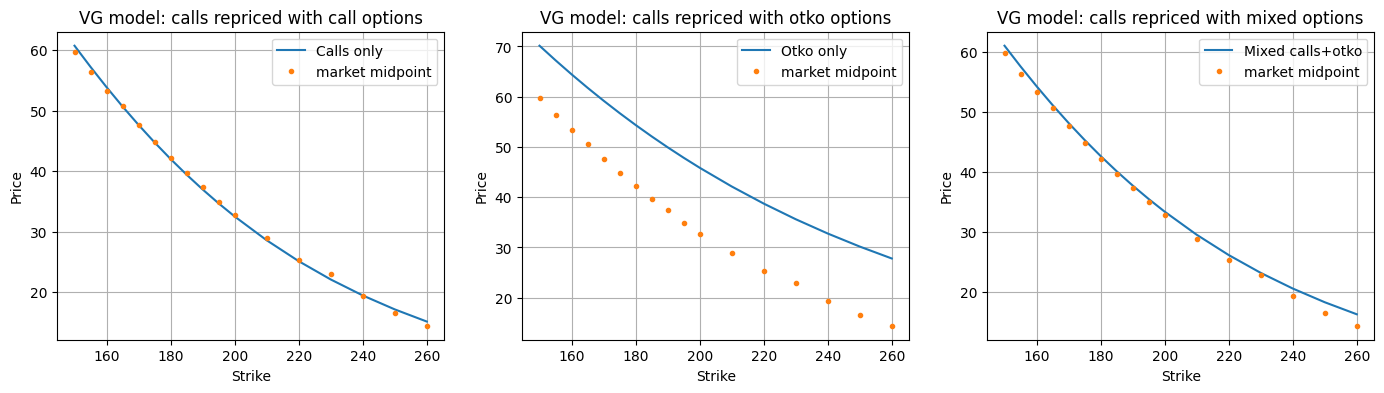

In [45]:
options = ['call', 'otko', 'mixed']
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, calls_vg_repriced_1, label="Calls only")
ax2.plot(call_strikes, calls_vg_repriced_3, label="Otko only")
ax3.plot(call_strikes, calls_vg_repriced_4, label="Mixed calls+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(call_strikes, call_prices, ".", label="market midpoint")
    ax.set_title(f"VG model: calls repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

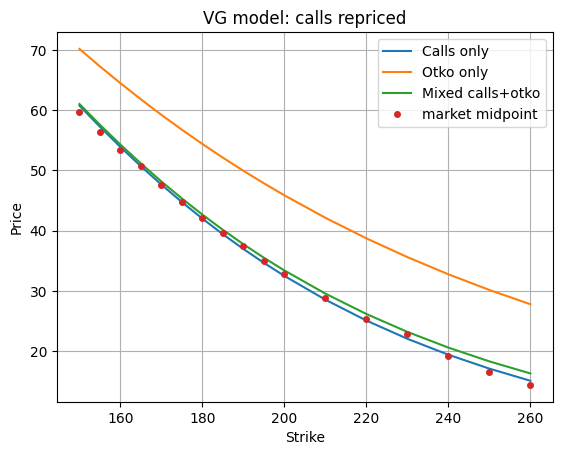

In [46]:
plt.plot(call_strikes, calls_vg_repriced_1, label="Calls only")
plt.plot(call_strikes, calls_vg_repriced_3, label="Otko only")
plt.plot(call_strikes, calls_vg_repriced_4, label="Mixed calls+otko")
plt.plot(call_strikes, call_prices, ".", label="market midpoint", markersize=8)
plt.title("VG model: calls repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [47]:
put_prices = puts['P_Midpoint']
put_strikes = puts['STRIKE']

puts_vg_repriced_2 = np.zeros(len(put_prices))
puts_vg_repriced_3 = np.zeros(len(put_prices))
puts_vg_repriced_5 = np.zeros(len(put_prices))

for index in range(len(put_strikes)):
    puts_vg_repriced_2[index] = VG2.closed_formula_put(put_strikes[index])  # SOLO CALLS PARAMETERS
    puts_vg_repriced_3[index] = VG3.closed_formula_put(put_strikes[index])  # SOLO OTKO PARAMETERS
    puts_vg_repriced_5[index] = VG5.closed_formula_put(put_strikes[index])  # MIXED CALLS+OTKO PARAMETERS

Repricing **PUTS**. The set of parameters used in our Merton Jump Diffusion will be:
1. Parameters calibrated on **put** options only
2. Parameters calibrated on **otko** options only
3. Parameters calibrated on **mixed** calibration, with **put** and **otko**

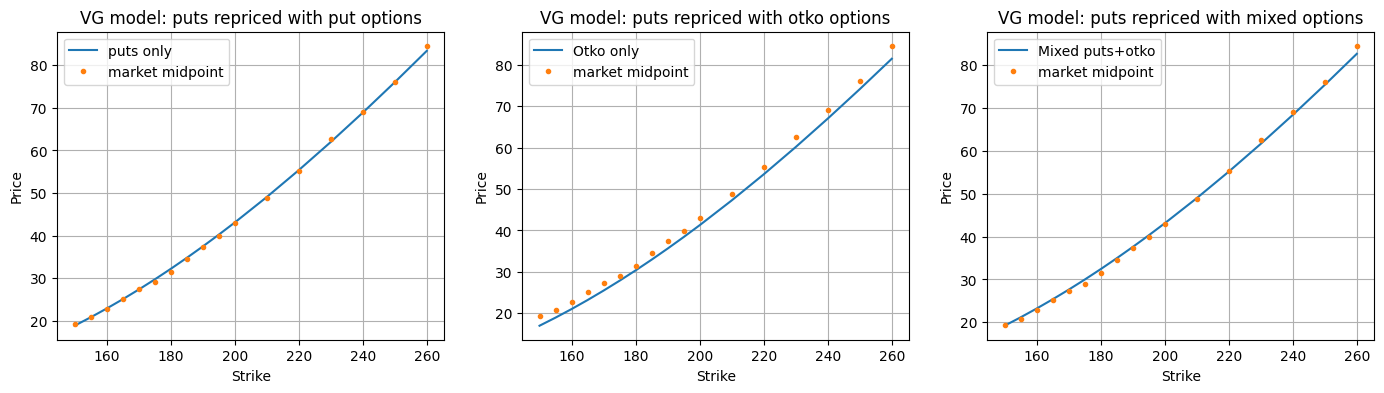

In [48]:
options = ['put', 'otko', 'mixed']

fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, puts_vg_repriced_2, label="puts only")
ax2.plot(put_strikes, puts_vg_repriced_3, label="Otko only")
ax3.plot(put_strikes, puts_vg_repriced_5, label="Mixed puts+otko")
for i in range(3):
    ax_ = f'ax{i+1}'
    ax = locals()[ax_]
    ax.plot(put_strikes, put_prices, ".", label="market midpoint")
    ax.set_title(f"VG model: puts repriced with {options[i]} options")
    ax.set_xlabel("Strike")
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()
plt.show()

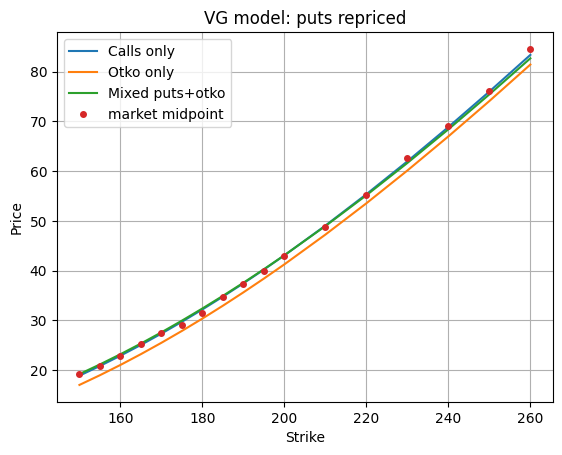

In [49]:
plt.plot(put_strikes, puts_vg_repriced_2, label="Calls only")
plt.plot(put_strikes, puts_vg_repriced_3, label="Otko only")
plt.plot(put_strikes, puts_vg_repriced_5, label="Mixed puts+otko")
plt.plot(put_strikes, put_prices, ".", label="market midpoint", markersize=8)
plt.title("VG model: puts repriced")
plt.xlabel("Strike")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### 1.2. Reprice OTKO options with all the set of parameters

In [50]:
otko_strikes = otko[['K1', 'K2']].values / 100
otko_prices = otko['Midpoint(%)']

otko_vg_repriced_1 = np.zeros(len(otko_prices))
otko_vg_repriced_2 = np.zeros(len(otko_prices))
otko_vg_repriced_3 = np.zeros(len(otko_prices))
otko_vg_repriced_4 = np.zeros(len(otko_prices))
otko_vg_repriced_5 = np.zeros(len(otko_prices))

for index in range(len(otko_strikes)):
    otko_vg_repriced_1[index] = VG1.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])      # SOLO CALLS PARAMETERS
    otko_vg_repriced_2[index] = VG2.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])      # SOLO PUTS PARAMETERS
    otko_vg_repriced_3[index] = VG3.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])      # SOLO OTKO PARAMETERS
    otko_vg_repriced_4[index] = VG4.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])      # MIXED CALLS*OTKO PARAMETERS
    otko_vg_repriced_5[index] = VG5.closed_formula_otko6(otko_strikes[index][0], otko_strikes[index][1])      # MIXED PUTS+OTKO PARAMETERS

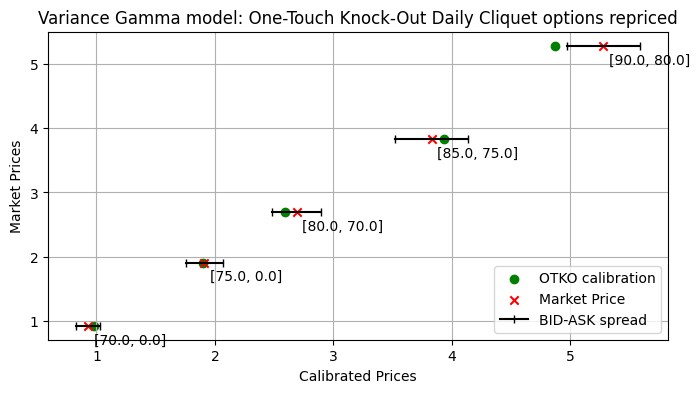

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(otko_vg_repriced_3, otko_prices, label='OTKO calibration', color='green', marker='o')

# Aggiunta di una linea di riferimento
plt.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')

# Aggiunta di etichette per i punti
for i in range(len(otko_strikes)):
    offset_x = 4
    offset_y = -13
    plt.annotate(f"[{otko_strikes[i][0]*100}, {otko_strikes[i][1]*100}]", (otko_prices[i], otko_prices[i]),
                 textcoords="offset points",
                 xytext=(offset_x, offset_y))

# Plot segments between bid, ask, and calibrated prices
for i in range(len(otko_strikes)):
    plt.plot([otko['BID(%)'][i], otko['ASK(%)'][i]], [otko_prices[i], otko_prices[i]], color='black', linestyle='-', marker='|')


# Aggiunta di etichette e titoli
plt.xlabel('Calibrated Prices')
plt.ylabel('Market Prices')
plt.title('Variance Gamma model: One-Touch Knock-Out Daily Cliquet options repriced')
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
handles.append(line) 
ax.legend(handles = handles, loc='lower right')
plt.grid()
# Mostra il grafico
plt.show()

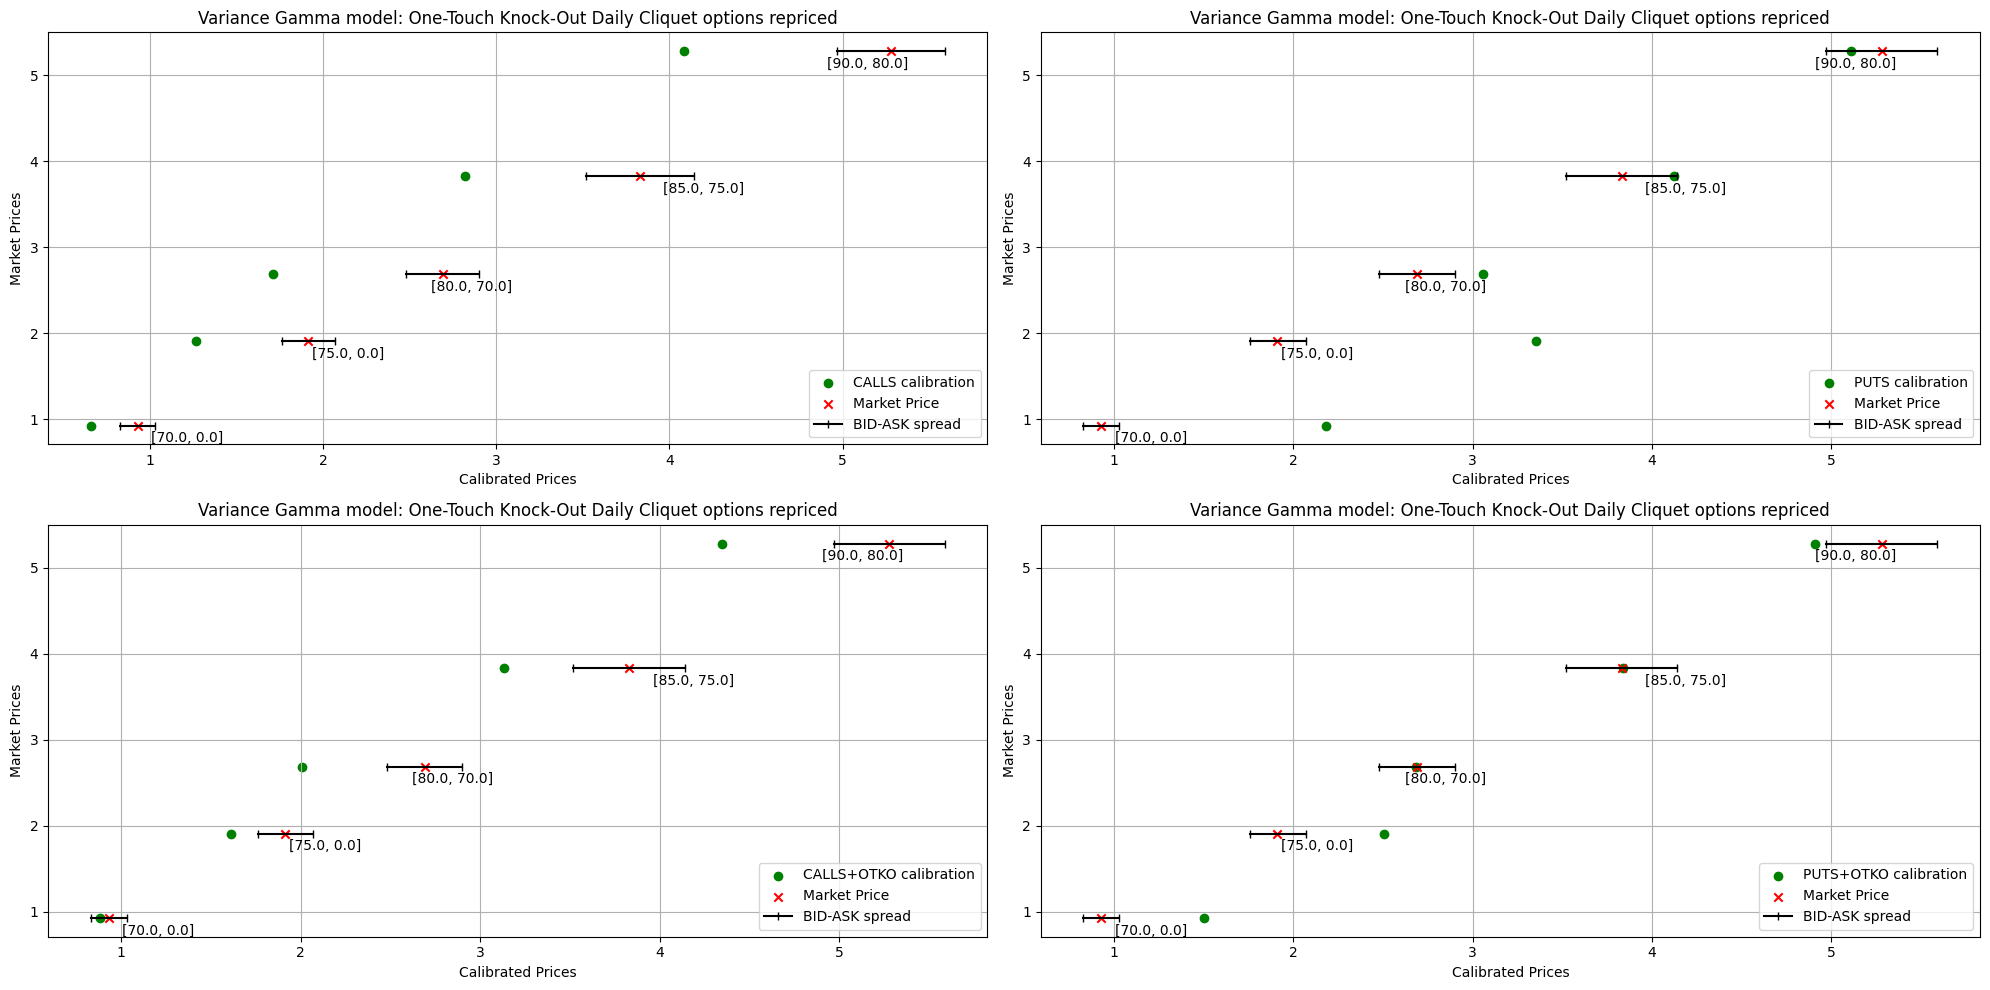

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes[0,0].scatter(otko_vg_repriced_1, otko_prices, label='CALLS calibration', color='green', marker='o')
axes[0,1].scatter(otko_vg_repriced_2, otko_prices, label='PUTS calibration', color='green', marker='o')
axes[1,0].scatter(otko_vg_repriced_4, otko_prices, label='CALLS+OTKO calibration', color='green', marker='o')
axes[1,1].scatter(otko_vg_repriced_5, otko_prices, label='PUTS+OTKO calibration', color='green', marker='o')

# Aggiunta di etichette per i punti
for i in range(2):
    for j in range(2):
        ax = axes[i, j]  # Get the current axis
        for k in range(len(otko_strikes)):
            offset_x = 4
            offset_y = -12
            ax.annotate(f"[{otko_strikes[k][0]*100}, {otko_strikes[k][1]*100}]", (otko_vg_repriced_3[k], otko_prices[k]),
                        textcoords="offset points",
                        xytext=(offset_x, offset_y))

        # Aggiunta di etichette e titoli per ogni subplot
        ax.set_xlabel('Calibrated Prices')
        ax.set_ylabel('Market Prices')
        ax.set_title('Variance Gamma model: One-Touch Knock-Out Daily Cliquet options repriced')
        ax.legend()

        # Plot reference lines and segments between bid, ask, and calibrated prices
        ax.scatter(otko_prices, otko_prices, color='red', marker='x', label='Market Price')
        for k in range(len(otko_strikes)):
            ax.plot([otko['BID(%)'][k], otko['ASK(%)'][k]], [otko_prices[k], otko_prices[k]], color='black', linestyle='-', marker='|')
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle = '-', drawstyle='steps-post', marker='|')
        handles.append(line) 
        ax.legend(handles = handles, loc='lower right')

# Adjust layout
plt.tight_layout()


# Mostra il grafico
plt.show()

### 2. Show the goodness of fit: adaptation error

In [53]:
def mean_outside_error(model_prices, mkt_bid, mkt_ask):

    outside_errors = [(model_prices[i] - mkt_ask[i]) / mkt_ask[i] if model_prices[i] > mkt_ask[i]
                      else (mkt_bid[i] - model_prices[i]) / mkt_bid[i] if model_prices[i] < mkt_bid[i]
                      else 0 for i in range(len(model_prices))]

    mean_outside_error = np.mean(outside_errors)

    return mean_outside_error

Let's compute the mean outside error for each type of option, using the set of parameters calibrated on the correspondant set of options. Meaning that, for each model (MJD, KJD and VG) the error of the **CALL PRICES** will be the relative distance between the CALL *model price* and the CALL *market price*.

In [54]:
errors_mert_prices = np.zeros(3)
# Call the function to compute the mean outside error
errors_mert_prices[0] = mean_outside_error(calls_mert_repriced_1, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS calibration
errors_mert_prices[1] = mean_outside_error(puts_mert_repriced_2, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS calibration
errors_mert_prices[2] = mean_outside_error(otko_mert_repriced_3, otko['BID(%)'], otko['ASK(%)'])            # parameters from OTKO calibration

print("Mean Outside Error for Merton model:", errors_mert_prices)

errors_kou_prices = np.zeros(3)
# Call the function to compute the mean outside error
errors_kou_prices[0] = mean_outside_error(calls_kou_repriced_1, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS calibration
errors_kou_prices[1] = mean_outside_error(puts_kou_repriced_2, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS calibration
errors_kou_prices[2] = mean_outside_error(otko_kou_repriced_3, otko['BID(%)'], otko['ASK(%)'])            # parameters from OTKO calibration

print("Mean Outside Error for KOU model:", errors_kou_prices)

errors_vg_prices = np.zeros(3)
# Call the function to compute the mean outside error
errors_vg_prices[0] = mean_outside_error(calls_vg_repriced_1, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS calibration
errors_vg_prices[1] = mean_outside_error(puts_vg_repriced_2, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS calibration
errors_vg_prices[2] = mean_outside_error(otko_vg_repriced_3, otko['BID(%)'], otko['ASK(%)'])            # parameters from OTKO calibration

print("Mean Outside Error for VG model:", errors_vg_prices)

Mean Outside Error for Merton model: [0.         0.01384569 0.02814999]
Mean Outside Error for KOU model: [3.90816870e-05 1.47951503e-03 1.82274256e-01]
Mean Outside Error for VG model: [0.         0.00015663 0.00380345]


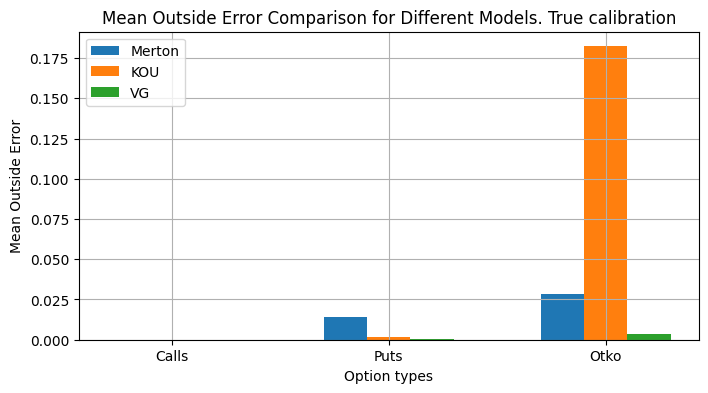

In [55]:
models = ['Merton', 'Kou', 'Variance Gamma']
options = ['Calls', 'Puts', 'Otko']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

bar_width = 0.2
index = np.arange(len(models))

# Plot the grouped bars for each model
ax.bar(index - bar_width, errors_mert_prices, bar_width, label='Merton')
ax.bar(index, errors_kou_prices, bar_width, label='KOU')
ax.bar(index + bar_width, errors_vg_prices, bar_width, label='VG')

# Add labels and title
ax.set_xlabel('Option types')
ax.set_ylabel('Mean Outside Error')
ax.set_title('Mean Outside Error Comparison for Different Models. True calibration')
ax.set_xticks(index)
ax.set_xticklabels(options)
ax.legend()
plt.grid(True)

# Show the plot
plt.show()

Let's compute the mean outside error for each type of option, using the set of parameters calibrated on the MIXEd set of options, i.e. vanilla + otko together. Meaning that, for each model (MJD, KJD and VG) the error of the **CALL PRICES** will be the relative distance between the CALL *model price* and the CALL+OTKO *market prices*.

In [56]:
errors_mert_prices2 = np.zeros(4)
# Call the function to compute the mean outside error

errors_mert_prices2[0] = mean_outside_error(calls_mert_repriced_4, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS+OTKO calibration
errors_mert_prices2[1] = mean_outside_error(puts_mert_repriced_5, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS+OTKO calibration
errors_mert_prices2[2] = mean_outside_error(otko_mert_repriced_4, otko['BID(%)'], otko['ASK(%)'])            # parameters from CALLS+OTKO calibration
errors_mert_prices2[3] = mean_outside_error(otko_mert_repriced_5, otko['BID(%)'], otko['ASK(%)'])            # parameters from PUTS+OTKO calibration

print("Mean Outside Error for Merton model:", errors_mert_prices2)

errors_kou_prices2 = np.zeros(4)
# Call the function to compute the mean outside error
errors_kou_prices2[0] = mean_outside_error(calls_kou_repriced_4, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS+OTKO calibration
errors_kou_prices2[1] = mean_outside_error(puts_kou_repriced_5, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS+OTKO calibration
errors_kou_prices2[2] = mean_outside_error(otko_kou_repriced_4, otko['BID(%)'], otko['ASK(%)'])            # parameters from CALLS+OTKO calibration
errors_kou_prices2[3] = mean_outside_error(otko_kou_repriced_5, otko['BID(%)'], otko['ASK(%)'])            # parameters from PUTS+OTKO calibration

print("Mean Outside Error for KOU model:", errors_kou_prices2)

errors_vg_prices2 = np.zeros(4)
# Call the function to compute the mean outside error
errors_vg_prices2[0] = mean_outside_error(calls_vg_repriced_4, calls['C_BID'], calls['C_ASK'])           # parameters from CALLS+OTKO calibration
errors_vg_prices2[1] = mean_outside_error(puts_vg_repriced_5, puts['P_BID'], puts['P_ASK'])              # parameters from PUTS+OTKO calibration
errors_vg_prices2[2] = mean_outside_error(otko_vg_repriced_4, otko['BID(%)'], otko['ASK(%)'])            # parameters from CALLS+OTKO calibration
errors_vg_prices2[3] = mean_outside_error(otko_vg_repriced_5, otko['BID(%)'], otko['ASK(%)'])            # parameters from PUTS+OTKO calibration
print("Mean Outside Error for VG model:", errors_vg_prices2)

Mean Outside Error for Merton model: [0.00488573 0.01388861 0.06523781 0.99999813]
Mean Outside Error for KOU model: [0.01331957 0.00112382 0.25646476 0.91803479]
Mean Outside Error for VG model: [0.00887137 0.00082292 0.10190276 0.13661415]


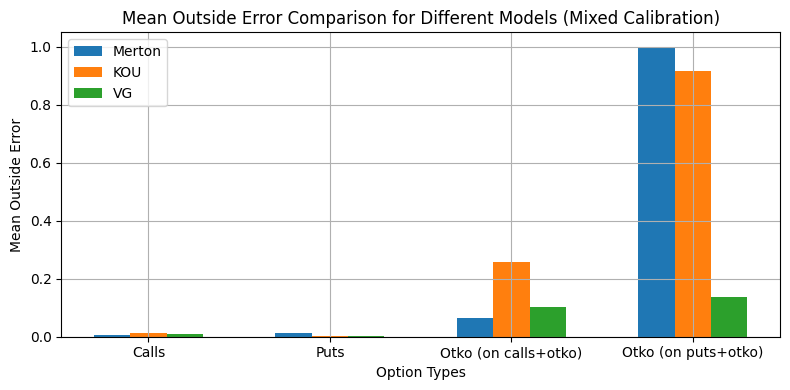

In [57]:
models = ['Merton', 'Kou', 'Variance Gamma']
options = ['Calls', 'Puts', 'Otko (on calls+otko)', 'Otko (on puts+otko)']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,4))

bar_width = 0.2
index = np.arange(len(options))

# Plot the grouped bars for each model
ax.bar(index - bar_width, errors_mert_prices2, bar_width, label='Merton')
ax.bar(index, errors_kou_prices2, bar_width, label='KOU')
ax.bar(index + bar_width, errors_vg_prices2, bar_width, label='VG')

# Add labels and title
ax.set_xlabel('Option Types')
ax.set_ylabel('Mean Outside Error')
ax.set_title('Mean Outside Error Comparison for Different Models (Mixed Calibration)')
ax.set_xticks(index)
ax.set_xticklabels(options)
ax.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()  # Ensure labels and ticks fit properly
plt.show()

### 3. Comparison with historical data
#### 3.1 Returns observed in real data vs simulated data

In [58]:
# plot of historical log returns 
data['Cumulative Log Returns'] = np.cumsum(data['Log Returns'], axis =0)
data_one_year = data.iloc[1:days, :]
print(data_one_year.head(3))
data_one_year['Log Returns'].describe()

         Date       Open       High        Low      Close    Volume   Returns  \
1  2016-01-21  53.746670  54.194668  52.005333  53.325333  47493000  1.006392   
2  2016-01-22  54.613331  54.799999  53.074669  54.013332  46861500  1.012902   
3  2016-01-25  53.349331  54.285332  52.234669  52.368000  40480500  0.969538   

   Log Returns  Returns (%)  Cumulative Log Returns  
1     0.006371     0.639151                0.006371  
2     0.012819     1.290193                0.019191  
3    -0.030935    -3.046160               -0.011745  


count    251.000000
mean       0.000725
std        0.024107
min       -0.110377
25%       -0.011370
50%        0.000956
75%        0.015021
max        0.083482
Name: Log Returns, dtype: float64

C:\Users\ornel\AppData\Local\Temp\ipykernel_1208\977694848.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['{:,.2f}'.format(x) for x in ax[0].get_xticks()])


Text(0, 0.5, 'Sample quantiles')

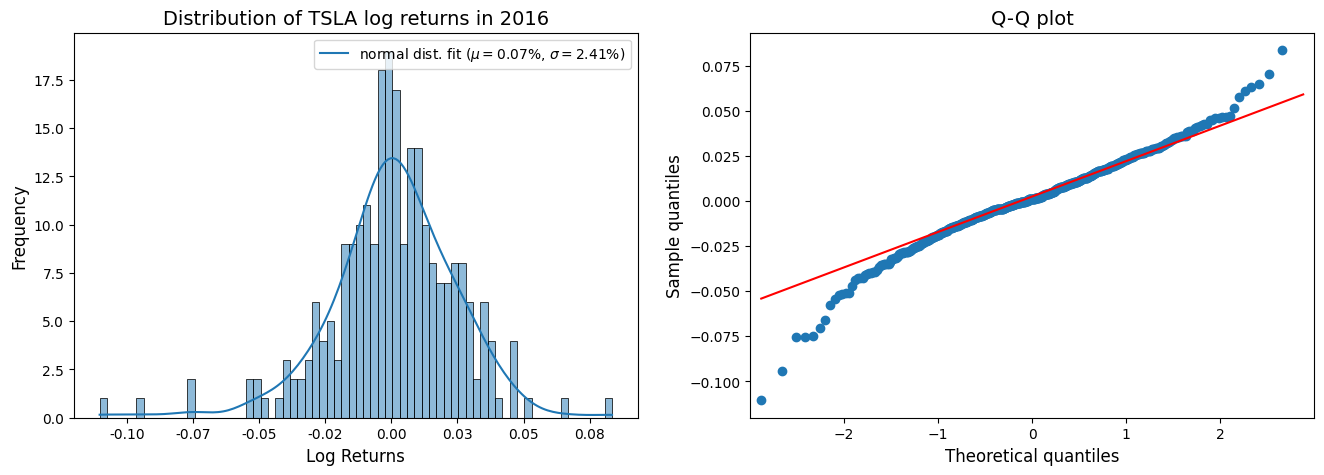

In [59]:
logreturns = data_one_year['Log Returns'].values
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(logreturns, ax=ax[0], bins=70, kde=True)
(mu, s) = stats.norm.fit(data_one_year['Log Returns'].values)
# Plot the normal distribution curve
x = np.linspace(min(logreturns), max(logreturns), 100)
y = stats.norm.pdf(x, mu, s)
#ax[0].plot(x, y, color='red', linestyle='-', linewidth=2)
ax[0].set_title('Distribution of TSLA log returns in 2016', fontsize=14)
ax[0].set_xlabel('Log Returns', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_xticklabels(['{:,.2f}'.format(x) for x in ax[0].get_xticks()])
ax[0].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=10)

# Subplot 2
# Obtaining Q-Q plot using qqplot function of statsmodels.api library
qq = sm.qqplot(data['Log Returns'].values, line='q', ax=ax[1])
#setting title and fontsize of the second plot
ax[1].set_title('Q-Q plot', fontsize = 14)
ax[1].set_xlabel('Theoretical quantiles', fontsize=12)
ax[1].set_ylabel('Sample quantiles', fontsize=12)

In [63]:
log_returns_mert3 = np.log(Smert3[1:, :] / Smert3[:-1, :])
lr_mert3_flattened = log_returns_mert3.flatten()
log_returns_kou3 = np.log(Skou3[1:, :] / Skou3[:-1, :])
lr_kou3_flattened = log_returns_kou3.flatten()
log_returns_vg3 = np.log(Svg3[1:, :] / Svg3[:-1, :])
lr_vg3_flattened = log_returns_vg3.flatten()

cum_log_returns_mert3 = np.cumsum(log_returns_mert3, axis=0)[-1, :]
cum_log_returns_kou3 = np.cumsum(log_returns_kou3, axis=0)[-1, :]
cum_log_returns_vg3 = np.cumsum(log_returns_vg3, axis=0)[-1, :]


Parameters calibrated on OTKO options only


C:\Users\ornel\AppData\Local\Temp\ipykernel_1208\977610882.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()])
C:\Users\ornel\AppData\Local\Temp\ipykernel_1208\977610882.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['{:,.1f}'.format(x) for x in ax[1].get_xticks()])
C:\Users\ornel\AppData\Local\Temp\ipykernel_1208\977610882.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(['{:,.1f}'.format(x) for x in ax[2].get_xticks()])


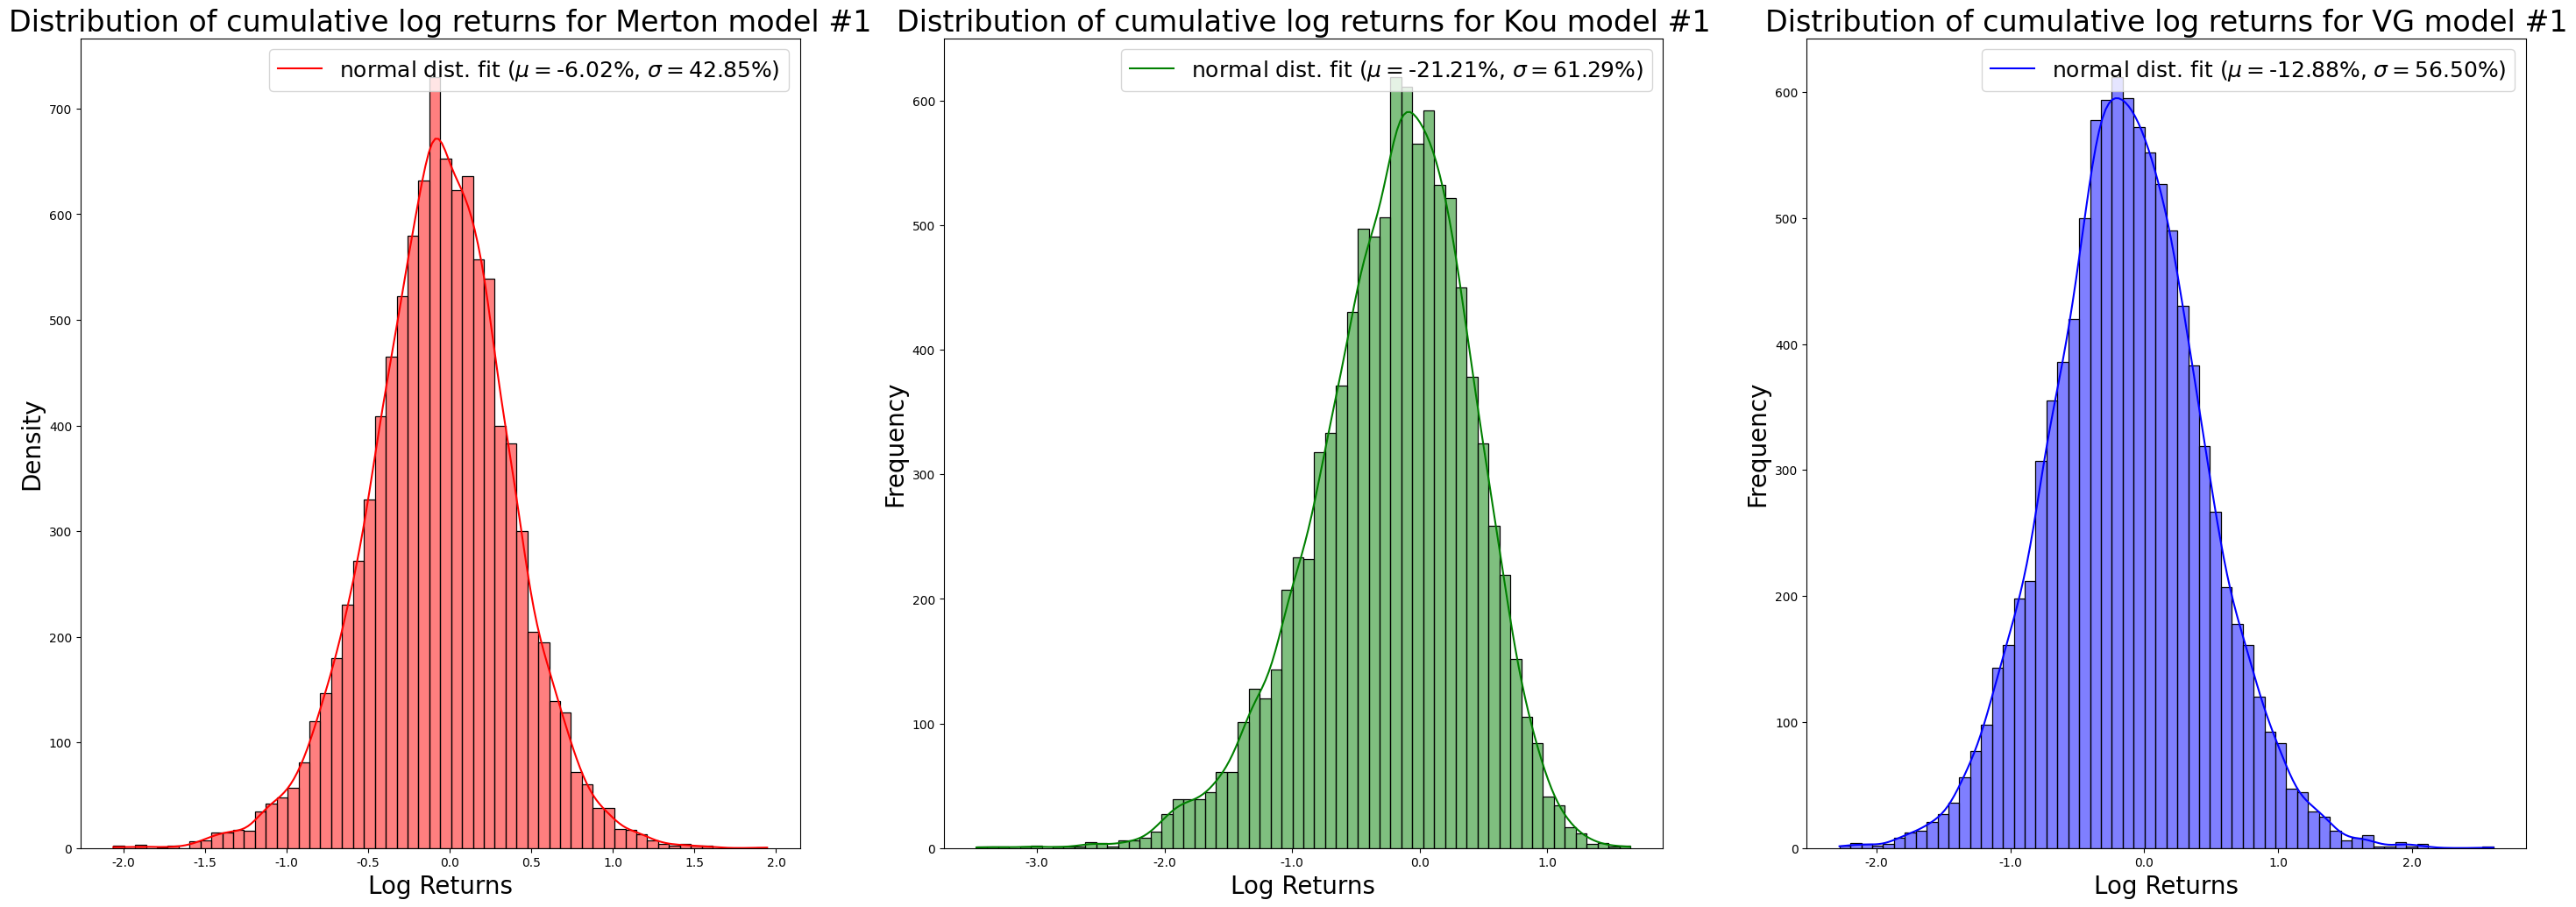

In [64]:
print('Parameters calibrated on OTKO options only')
fig, ax = plt.subplots(ncols=3, figsize=(36,12))

# fit a dist plot
sns.histplot(cum_log_returns_mert3, ax=ax[0], bins=60, kde=True, color= 'red')
sns.histplot(cum_log_returns_kou3, ax=ax[1], bins=60, kde=True, color= 'green')
sns.histplot(cum_log_returns_vg3, ax=ax[2], bins=60, kde=True, color= 'blue')

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(cum_log_returns_mert3) #, color='red', linewidth = 20)
ax[0].set_title('Distribution of cumulative log returns for Merton model #1', fontsize=24)
ax[0].set_xlabel('Log Returns', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()])
ax[0].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18)

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(cum_log_returns_kou3)
ax[1].set_title('Distribution of cumulative log returns for Kou model #1', fontsize=24)
ax[1].set_xlabel('Log Returns', fontsize=20)
ax[1].set_ylabel('Frequency', fontsize=20)
ax[1].set_xticklabels(['{:,.1f}'.format(x) for x in ax[1].get_xticks()])
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18)

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(cum_log_returns_vg3)
ax[2].set_title('Distribution of cumulative log returns for VG model #1', fontsize=24)
ax[2].set_xlabel('Log Returns', fontsize=20)
ax[2].set_ylabel('Frequency', fontsize=20)
ax[2].set_xticklabels(['{:,.1f}'.format(x) for x in ax[2].get_xticks()])
ax[2].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18)


#### Plot all the daily log returns for the simulated paths

Parameters calibrated on OTKO options only
Daily Log Returns of simulated paths (all together)


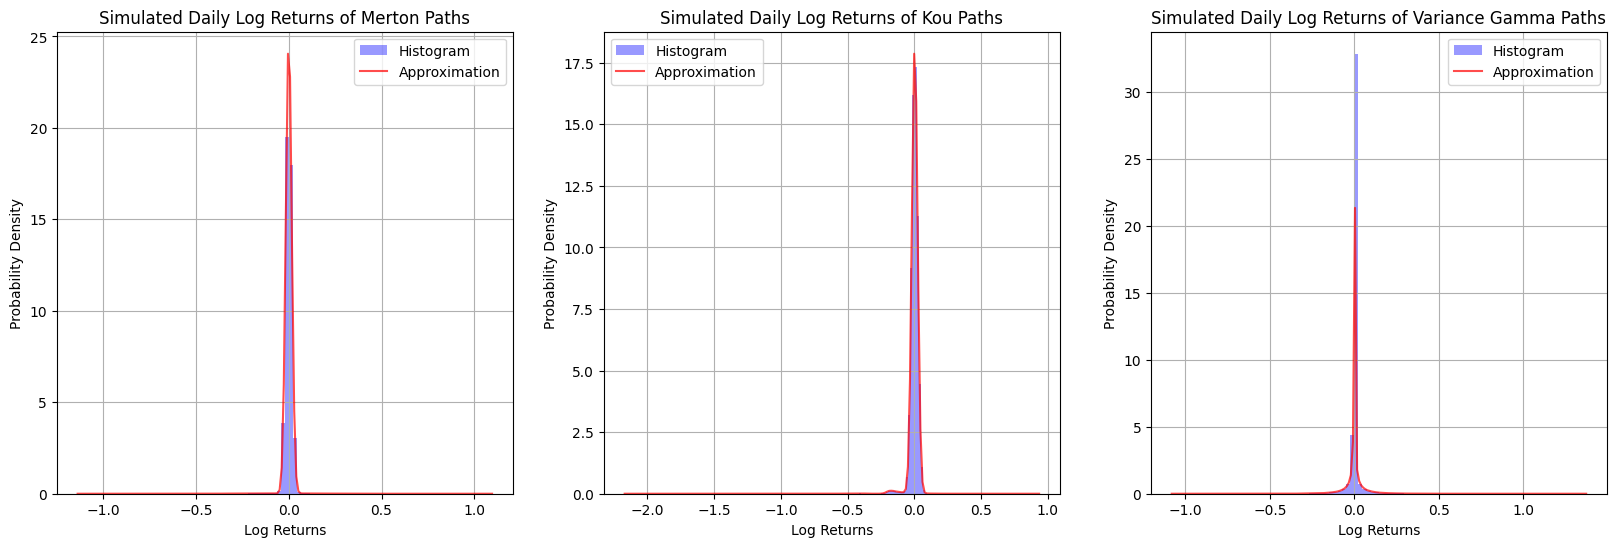

In [67]:
models = ['Merton', 'Kou', 'Variance Gamma']
print('Parameters calibrated on OTKO options only')
# Create histogram using Matplotlib
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
print('Daily Log Returns of simulated paths (all together)')

axes[0].hist(lr_mert3_flattened, bins=100, density=True, alpha=0.4, color='blue', label='Histogram')
axes[1].hist(lr_kou3_flattened, bins=200, density=True, alpha=0.4, color='blue', label='Histogram')
axes[2].hist(lr_vg3_flattened, bins=100, density=True, alpha=0.4, color='blue', label='Histogram')

mert_lr_1_approx_line = sns.kdeplot(lr_mert3_flattened, color='r', label='Approximation', ax=axes[0], alpha=0.7)
kou_lr_1_approx_line = sns.kdeplot(lr_kou3_flattened, color='r', label='Approximation', ax=axes[1], alpha=0.7)
vg_lr_1_approx_line = sns.kdeplot(lr_vg3_flattened, color='r', label='Approximation', ax=axes[2], alpha=0.7)

for i in range(3):
    # Add labels and title
    axes[i].set_xlabel('Log Returns')
    axes[i].set_ylabel('Probability Density')
    axes[i].set_title(f'Simulated Daily Log Returns of {models[i]} Paths')
    axes[i].legend()
    axes[i].grid(True)

plt.show()